# Classification Project - Telco Churn 

## Project Goal

- Find drivers for customer churn at Telco
- Construct a ML classification model that accurately predicts customer churn
- Document your process well enough to be presented or read like a report

### Executive Summary

Findings:
- Drivers of churn were contract type, payment type and total charges
- Analysis showed that churn rate went down as tenure increases
- Classification model predicts whether a customer will churn with 78% accuracy

Recommendations:
- Offer incentivise to enroll in automatic payment
- Offer incentivise to enroll in a yearly contract
- Work with marketing to test offers to increase retention, e.g. Special promo during customer cancelation
- A/B channel testing
- Work with UX to determine if the customer onboarding process simplifies the automatic payment types


# Imports

In [1]:
# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# helper function imports
from acquire import get_telco_project, get_telco_churn, get_connection
from prepare import clean_telco_churn, telco_churn_split, prep_telco_churn

import pandas as pd
import numpy as np
from scipy import stats

# visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# preparing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# modeling/evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

# Data Acquisition

In [2]:
# acquire function to obtain dataframe

df = get_telco_project()

In [3]:
# look at dataframe

df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [4]:
# summarize the dataframe

print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
print('____________________________________________')
print('')
print('Looking at the data types:')
print('--------------------------')
print('')
print(df.info())

This dataframe has 7043 rows and 24 columns.
____________________________________________

Looking at the data types:
--------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7

# Data Preparation

- Create dummies and drop redundant columns
- Create new column "is_female" -- Female = 1, Male = 0
- Service details (online backup, tech_support, etc.): Change Yes/no into 1/0
- Churn: Change Yes/no into 1/0
- Partner and dependents: Change Yes/no to 1/0
- 11 blank values in total_charges, represented only new customers w/less than 1 month of tenure, replaced the blanks with a 0 (float)
- Create new column is_auto_pay - identifys if customer pays automatically or manually. 1 is True, 0 is False

In [5]:
# looking for missing values

df.isna().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

### **Split our data**

In [6]:
train, validate, test = prep_telco_churn(df)

print(f'The shape of the train dataset is: {train.shape}')
print(f'The shape of the validate dataset is: {validate.shape}')
print(f'The shape of the test dataset is: {test.shape}')

The shape of the train dataset is: (3943, 32)
The shape of the validate dataset is: (1691, 32)
The shape of the test dataset is: (1409, 32)


Train dataset will be used for explorations and modeling before moving on to validate and test.

In [7]:
# look at train dataframe.

train.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,dsl,fiber_optic,no_internet,monthly,one_year,two_year,bank_transfer,credit_card,electronic_check,mailed_check
5642,1982-FEBTD,0,1,1,23,1,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3338,8982-NHAVY,0,0,0,27,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
4273,4115-NZRKS,1,0,0,7,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2382,9633-DENPU,0,1,0,47,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
2655,5693-PIPCS,0,0,0,41,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5642 to 6840
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3943 non-null   object 
 1   senior_citizen         3943 non-null   int64  
 2   partner                3943 non-null   int64  
 3   dependents             3943 non-null   int64  
 4   tenure                 3943 non-null   int64  
 5   phone_service          3943 non-null   int64  
 6   multiple_lines         3943 non-null   int64  
 7   online_security        3943 non-null   int64  
 8   online_backup          3943 non-null   int64  
 9   device_protection      3943 non-null   int64  
 10  tech_support           3943 non-null   int64  
 11  streaming_tv           3943 non-null   int64  
 12  streaming_movies       3943 non-null   int64  
 13  paperless_billing      3943 non-null   int64  
 14  monthly_charges        3943 non-null   float64
 15  t

# Data Exploration & Analysis

Using train dataset for this stage

- Determine drivers of churn
- Visualize data
- Run statistical tests
- Set the baseline model

## Create a baseline to compare models against 

In [9]:
# Overall churn rate

train.churn.value_counts(normalize=True)

0    0.73472
1    0.26528
Name: churn, dtype: float64

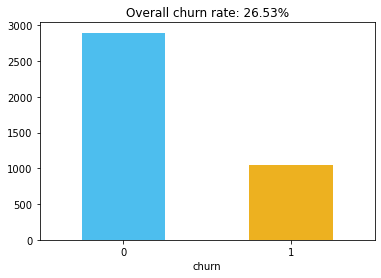

In [24]:
# Visualization at the overall churn rate.

train.churn.value_counts().sort_index().plot.bar(color={'#EDB120','#4DBEEE'})
churn_rate = train.churn.mean()
plt.title(f'Overall churn rate: {churn_rate:.2%}')
plt.xlabel('churn')
plt.xticks(rotation = 0) 
plt.show()

When testing models for rate of churn, we should aim for accuracy higher than 73%

## Compare rate of churn against tenure length

In [25]:
# Create new column 'tenure_year'

explore_df = train
explore_df['tenure_year'] = round(explore_df.tenure / 12)

In [26]:
# Rate of churn for customers that have 1 year or less of tenure 

mask1 = explore_df.tenure_year <= 1
one_year = explore_df[mask1]
one_year.churn.value_counts(normalize=True)

0    0.545957
1    0.454043
Name: churn, dtype: float64

In [27]:
# Rate of churn for customers that have 2 years of tenure

mask2 = (explore_df.tenure_year > 1) & (explore_df.tenure_year <= 2)
two_years = explore_df[mask2]
two_years.churn.value_counts(normalize=True)

0    0.767888
1    0.232112
Name: churn, dtype: float64

In [28]:
# Rate of churn for customers that have 3 years of tenure

mask3 = (explore_df.tenure_year > 2) & (explore_df.tenure_year <= 3)
three_years = explore_df[mask3]
three_years.churn.value_counts(normalize=True)

0    0.77193
1    0.22807
Name: churn, dtype: float64

In [29]:
# Rate of churn for customers that have greater than 3 years of tenure

mask4 = (explore_df.tenure_year > 3)
more_years = explore_df[mask4]
more_years.churn.value_counts(normalize=True)

0    0.891732
1    0.108268
Name: churn, dtype: float64

Takeaway:
- As tenure increases, churn decreases
- Largest rate of churn was found in 1 year or less

## Visualization for comparison

Are monthly charges an indicator if someone churns? 
- It appears customers that have higher monthly charges churn more often

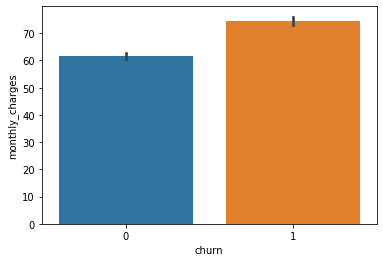

In [30]:
sns.barplot(x = 'churn', y = 'monthly_charges', data = train)
plt.show()

Is payment type an indicator if someone churns? 
- It appears customers that are using an automatic payment type is less likely to churn

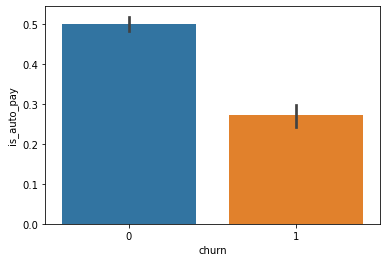

In [31]:
sns.barplot(x = 'churn', y = 'is_auto_pay', data = train)
plt.show()

Is contract type type an indicator if someone churns?
- Contract types also showing a visble rate of churn variable

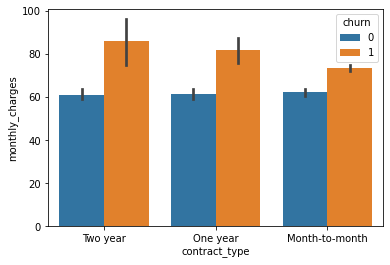

In [32]:
sns.barplot(x = 'contract_type', y = 'monthly_charges', hue = 'churn', data = train)
plt.show()

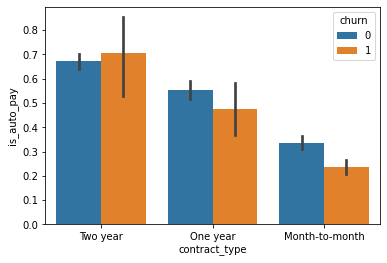

In [33]:
sns.barplot(x = 'contract_type', y = 'is_auto_pay', hue = 'churn', data = train)
plt.show()

Looking into the automatic payment type, customers that churn more often do not have an automatic payment type.

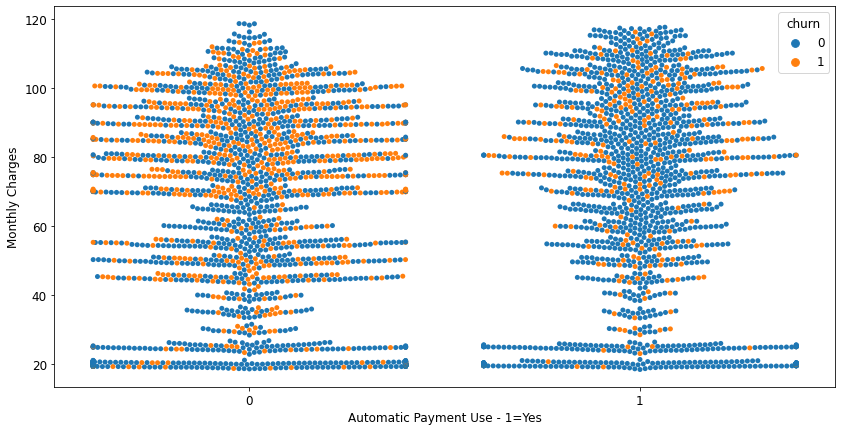

In [42]:
plt.rc('figure', figsize=(14, 7))
plt.rc('font', size=12)

sns.swarmplot(x = 'is_auto_pay', y = 'monthly_charges', data = train, hue = 'churn')
plt.xlabel('Automatic Payment Use - 1=Yes')
plt.ylabel('Monthly Charges')
plt.show()

Takeaway:
- Need to run a statistical test to validate if automatic payment type is a driver of churn

Heatmap to show correlation between variables and whether or not they churned?

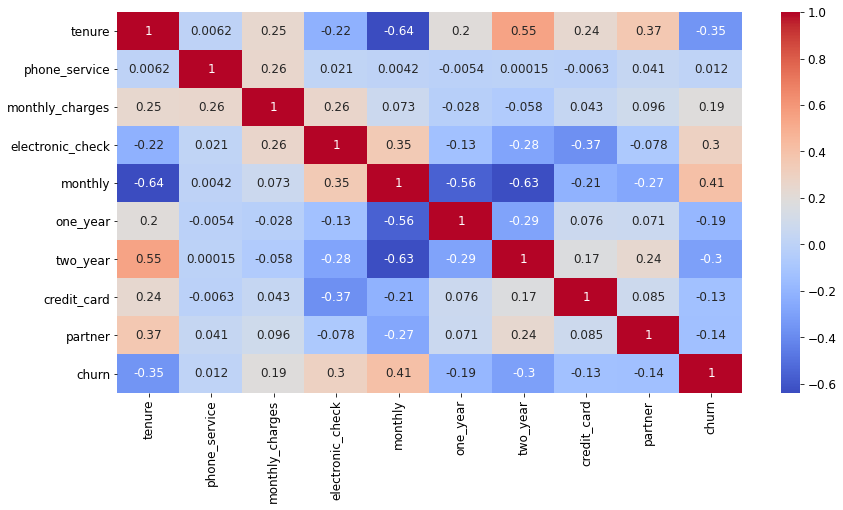

In [43]:
heatmap_columns = ['tenure', 'phone_service', 'monthly_charges', 'electronic_check', 'monthly', 'one_year', 
                   'two_year', 'credit_card', 'partner', 'churn']

corr = explore_df[heatmap_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Takeaway:**
- monthly_charges and electronic_check have high correlation with churn
- credit_card was one of the lowest correlation with churn

## Hypothesis and testing

Hypothesis 1

- $H_0$: There is no association between contract type and customer churn
- $H_a$: There is a association between contract type and customer churn

In [44]:
# set alpha

alpha = 0.05

In [45]:
# Create crosstab

crosstab = pd.crosstab(explore_df.churn, explore_df.contract_type)
crosstab

contract_type,Month-to-month,One year,Two year
churn,,,
0,1234,723,940
1,928,84,34


In [46]:
# contingency table test - chi^2 test

chi2, p, degf, expected = stats.chi2_contingency(crosstab)

print(f'The p-value is: {p:.4}')
print(f'The chi2 value is: {chi2:.4}')

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

The p-value is: 2.008e-146
The chi2 value is: 671.0
We reject the null hypothesis


**Hypothesis Test 1 Result**
- We rejected the null hypothesis, indicating there is some relationship between contract type and churn.

Hypothesis 2

- $H_0$: There is no association between automatic payment type and customer churn.
- $H_a$: There is a association between automatic payment type and customer churn.

In [47]:
# set alpha

alpha = 0.05

In [48]:
# Create crosstab2

crosstab2 = pd.crosstab(explore_df.churn, explore_df.is_auto_pay)
crosstab2

is_auto_pay,0,1
churn,,
0,1450,1447
1,762,284


In [49]:
# contingency table test - chi^2 test

chi2, p, degf, expected = stats.chi2_contingency(crosstab2)

print(f'p-value is: {p:.4}')
print(f'chi2 value is: {chi2:.4}')

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

p-value is: 6.028e-37
chi2 value is: 161.3
We reject the null hypothesis


**Hypothesis Test 2 Result:**
- We rejected the null hypothesis, indicating there is some relationship between automatic payment type and churn.

# Modeling and Evaluation

Using logistic regression, decision tree, and random forest models.

Baseline is at 73%

**Define the features (X-variable) and target (churn). Features used from visualizations and statistical testing**

In [50]:
X_cols = ['is_auto_pay', 'monthly', 'one_year', 'two_year', 'monthly_charges', 'total_charges']
y_col = 'churn'

X_train, y_train = train[X_cols], train[y_col]
X_validate, y_validate = validate[X_cols], validate[y_col]
X_test, y_test = test[X_cols], test[y_col]

## Train

### Model 1: Logistic Regression

In [100]:
# Create the model
logit = LogisticRegression(C = 1.0, random_state=123)

# Fit the model
logit.fit(X_train, y_train)

# Use the model
y_pred1 = logit.predict(X_train)

# Probability of churning
y_pred_prob1 = logit.predict_proba(X_train)

print(f'Model 1 accuracy score: {logit.score(X_train, y_train):.2%}')

Model 1 accuracy score: 78.95%


In [77]:
model_1 = pd.DataFrame(classification_report(train.churn, y_pred1, output_dict=True))
model_1

,0,1,accuracy,macro avg,weighted avg
precision,0.829455,0.633995,0.7895,0.731725,0.777603
recall,0.898171,0.488528,0.7895,0.693349,0.789500
f1-score,0.862446,0.551836,0.7895,0.707141,0.780047
support,2897.000000,1046.000000,0.7895,3943.000000,3943.000000


Takeaway:
- Model 1 performed better than the baseline 73%, with an accuracy of 79%

### Model 2: Decision Tree

In [78]:
# Create the model
dt = DecisionTreeClassifier(max_depth=5, random_state=123)

# Fit the model
dt.fit(X_train, y_train)

# Use the model
y_pred2 = dt.predict(X_train)

# Probability of churning
y_pred_prob2 = dt.predict_proba(X_train)

print(f'Model 2 accuracy score: {dt.score(X_train, y_train):.2%}')

Model 2 accuracy score: 79.51%


In [79]:
model_2 = pd.DataFrame(classification_report(train.churn, y_pred2, output_dict=True))
model_2

,0,1,accuracy,macro avg,weighted avg
precision,0.836393,0.642005,0.79508,0.739199,0.784826
recall,0.896445,0.514340,0.79508,0.705392,0.795080
f1-score,0.865378,0.571125,0.79508,0.718252,0.787319
support,2897.000000,1046.000000,0.79508,3943.000000,3943.000000


**Takeaways:**
- Accuracy is slightly higher than logistic regression model
- Recall is slightly higher

### Model 3: Random Forest

In [80]:
# Create the model
rf = RandomForestClassifier(bootstrap=True, min_samples_leaf=10, n_estimators=100, max_depth=20, random_state=123)

# Fit the model
rf.fit(X_train, y_train)

# Use the model
y_pred3 = rf.predict(X_train)

# Probability of churning
y_pred_prob3 = rf.predict_proba(X_train)

print(f'Model 3 accuracy score: {rf.score(X_train, y_train):.2%}')

Model 3 accuracy score: 83.31%


In [81]:
model_3 = pd.DataFrame(classification_report(train.churn, y_pred3, output_dict=True))
model_3

,0,1,accuracy,macro avg,weighted avg
precision,0.856642,0.741294,0.833122,0.798968,0.826043
recall,0.928202,0.569790,0.833122,0.748996,0.833122
f1-score,0.890987,0.644324,0.833122,0.767656,0.825553
support,2897.000000,1046.000000,0.833122,3943.000000,3943.000000


Takeaway:
- Performs better on all metrics than previous two models

## Validate

Using the top two performing models, **decision tree and random forest**. Will apply them to the validate dataset. This will help determine which one that should used on the test dataset.

### Decision Tree Validation

In [82]:
# Use the model to create predictions
y_pred_validate1 = dt.predict(X_validate)

# Probability of churning
y_pred_prob_validate1 = dt.predict_proba(X_validate)

print(f'Decision Tree accuracy score: {dt.score(X_validate, y_validate):.2%}')

Decision Tree accuracy score: 77.41%


In [83]:
model_dt = pd.DataFrame(classification_report(validate.churn, y_pred_validate1, output_dict=True))
model_dt

,0,1,accuracy,macro avg,weighted avg
precision,0.818991,0.597668,0.774098,0.708329,0.760225
recall,0.888889,0.456570,0.774098,0.672730,0.774098
f1-score,0.852510,0.517677,0.774098,0.685093,0.763604
support,1242.000000,449.000000,0.774098,1691.000000,1691.000000


### Random Forest Validation

In [84]:
# Use the model to create predictions
y_pred_validate2 = rf.predict(X_validate)

# Probability of churning
y_pred_prob_validate2 = rf.predict_proba(X_validate)

print(f'Random Forest accuracy score: {rf.score(X_validate, y_validate):.2%}')

Random Forest accuracy score: 78.65%


In [85]:
model_rf = pd.DataFrame(classification_report(validate.churn, y_pred_validate2, output_dict=True))
model_rf

,0,1,accuracy,macro avg,weighted avg
precision,0.823659,0.633333,0.786517,0.728496,0.773123
recall,0.902576,0.465479,0.786517,0.684028,0.786517
f1-score,0.861314,0.536585,0.786517,0.698950,0.775091
support,1242.000000,449.000000,0.786517,1691.000000,1691.000000


Takeaway:
- Performance between these two models are similar in the validate stage
- Decision tree accuracy lowered 2 percentage points from 79.5 to 77.4, while random forest lowered 5 percentage points from 83.3 to 78.6

## Test

The decision tree model has the lowest drop percentage in accuracy between train and validat. Will be running the decision tree model through the test dataset

In [86]:
# Use the model to create predictions

y_pred_test = dt.predict(X_test)

# Probability of churning

y_pred_prob_test = dt.predict_proba(X_test)

print(f'Test model accuracy score: {dt.score(X_test, y_test):.2%}')

Test model accuracy score: 78.85%


In [87]:
test_model = pd.DataFrame(classification_report(test.churn, y_pred_test, output_dict=True))
test_model

,0,1,accuracy,macro avg,weighted avg
precision,0.838384,0.618750,0.788502,0.728567,0.780085
recall,0.882126,0.529412,0.788502,0.705769,0.788502
f1-score,0.859699,0.570605,0.788502,0.715152,0.782963
support,1035.000000,374.000000,0.788502,1409.000000,1409.000000


How the test model did by looking at the confusion matrix

In [88]:
pd.crosstab(test.churn, y_pred_test, margins=True, normalize=True)

col_0,0,1,All
churn,,,
0,0.647977,0.086586,0.734564
1,0.124911,0.140525,0.265436
All,0.772889,0.227111,1.000000


## Predicting rate of churn

In [89]:
# making .csv file containing the test sample with predictions from chosen model

In [90]:
#reset the index

reset_test = test.reset_index()

In [91]:
test_proba_df = pd.DataFrame(y_pred_prob_test, columns=['no_churn', 'churn_prob'])

In [92]:
test_proba_df

,no_churn,churn_prob
0,1.000000,0.000000
1,0.736842,0.263158
2,0.596154,0.403846
3,1.000000,0.000000
4,0.485437,0.514563
...,...,...
1404,0.838710,0.161290
1405,0.048387,0.951613
1406,0.981728,0.018272
1407,0.914286,0.085714


In [93]:
# concatenate reset test and test probabilities

test_proba_df = pd.concat([reset_test, test_proba_df['churn_prob']], axis=1)

In [94]:
test_proba_df['predicted'] = y_pred_test

In [95]:
test_proba_df

,index,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,no_internet,monthly,one_year,two_year,bank_transfer,credit_card,electronic_check,mailed_check,churn_prob,predicted
0,2789,8670-ERCJH,0,0,0,72,1,1,1,1,...,0,0,0,1,1,0,0,0,0.000000,0
1,1233,0356-ERHVT,0,1,0,11,1,0,0,0,...,0,1,0,0,1,0,0,0,0.263158,0
2,6784,4786-UKSNZ,0,0,0,1,1,0,0,0,...,1,1,0,0,0,0,0,1,0.403846,0
3,3177,5945-AZYHT,0,1,0,71,1,1,1,1,...,0,0,1,0,0,0,1,0,0.000000,0
4,1740,4432-ADRLB,0,0,0,2,1,0,0,0,...,0,1,0,0,0,0,0,1,0.514563,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1900,5650-VDUDS,0,0,0,4,0,0,0,0,...,0,1,0,0,0,0,0,1,0.161290,0
1405,5451,9725-SCPZG,0,0,1,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0.951613,1
1406,6142,9764-REAFF,0,1,0,59,1,0,0,0,...,1,0,0,1,1,0,0,0,0.018272,0
1407,2186,7964-YESJC,0,1,0,24,1,1,1,1,...,0,1,0,0,0,0,0,1,0.085714,0


In [96]:
# create new dataframe with 3 columns

csv = test_proba_df[['customer_id', 'predicted', 'churn_prob']]

In [97]:
csv

,customer_id,predicted,churn_prob
0,8670-ERCJH,0,0.000000
1,0356-ERHVT,0,0.263158
2,4786-UKSNZ,0,0.403846
3,5945-AZYHT,0,0.000000
4,4432-ADRLB,1,0.514563
...,...,...,...
1404,5650-VDUDS,0,0.161290
1405,9725-SCPZG,1,0.951613
1406,9764-REAFF,0,0.018272
1407,7964-YESJC,0,0.085714


In [98]:
# Write DataFrame to a csv for deliverable.

csv.to_csv('telco_churn_predictions.csv')

In [99]:
csv.predicted.value_counts()

0    1089
1     320
Name: predicted, dtype: int64

Model predicted 320 customers would churn out of the test dataset

## Conclusions

- The baseline model was set at 73%
- Test model accuracy score: 78%
- Decision tree model ran on the train, validate, and test datasets. This model consistently outperformed baseline
- Model predicted 320 customers would churn out of the test dataset

**Recommendations:** 
- Offer incentivise to enroll in automatic payment
- Offer incentivise to enroll in a yearly contract
- Work with marketing to test offers to increase retention, e.g. Special promo during customer cancelation
- A/B channel testing
- Work with UX to determine if the customer onboarding process simplifies the automatic payment types